# **Importar dataframe de Google Drive**

In [64]:
# Incluir definición de parámetros
%run -i '/content/drive/MyDrive/TFM/0.config.py'

Usando DS_FILE       : /content/drive/MyDrive/TFM/etherdata-MINUTE-2021-09-01-2021-11-30.csv
Usando DS_FILE_CLEAN : /content/drive/MyDrive/TFM/etherdata-MINUTE-2021-09-01-2021-11-30-CLEAN.csv


<Figure size 432x288 with 0 Axes>

In [65]:
# Importaciones
from google.colab import auth
from google.cloud import bigquery

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import statsmodels.api as sm

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

from scipy import stats

print(tf.__version__)

2.7.0


In [66]:
# Cargar Dataframe de Google Drive
df_org = pd.read_csv(DS_FILE)

# **Revisar y Limpiar Datos**

In [67]:
# Convertir blk_timestamp de  tipo object a timestamp
df_org['time'] =  df_org['time'].apply (pd.to_datetime)

# Eliminar columna 'Unnamed: 0'
df_org=df_org.drop(columns=['Unnamed: 0'])

Buscar y eliminar filas con datos faltantes

In [68]:
df_org.isna().sum()

time                      0
avg_gas_price            11
min_gas_price            11
max_gas_price            11
avg_base_fee_per_gas      0
avg_difficulty            0
avg_gas_limit             0
avg_gas_used              0
avg_size                  0
avg_transaction_count     0
sum_tx_ether             11
num_blk                   0
num_trn                  11
dtype: int64

In [69]:
# Eliminar columna max_gas_price  
#_ = df_org.pop('max_gas_price')

In [70]:
# Eliminar columna avg_base_fee_per_gas si necesario  
if DROP_avg_base_fee_per_gas :
  _ = df_org.pop('avg_base_fee_per_gas')

In [71]:
# Eliminar filas con elementos vacíos
df_org = df_org.dropna()

In [72]:
# Separar indice de tiempos
times = df_org.pop('time')

In [73]:
df_org.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 129716 entries, 0 to 129726
Data columns (total 12 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   avg_gas_price          129716 non-null  float64
 1   min_gas_price          129716 non-null  float64
 2   max_gas_price          129716 non-null  float64
 3   avg_base_fee_per_gas   129716 non-null  float64
 4   avg_difficulty         129716 non-null  float64
 5   avg_gas_limit          129716 non-null  float64
 6   avg_gas_used           129716 non-null  float64
 7   avg_size               129716 non-null  float64
 8   avg_transaction_count  129716 non-null  float64
 9   sum_tx_ether           129716 non-null  float64
 10  num_blk                129716 non-null  int64  
 11  num_trn                129716 non-null  float64
dtypes: float64(11), int64(1)
memory usage: 12.9 MB


In [74]:
df_org.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
avg_gas_price,129716.0,1.264246e+02,1.766149e+02,3.123343e+01,8.177163e+01,1.120963e+02,1.489301e+02,4.936640e+04
min_gas_price,129716.0,9.980102e+01,7.194226e+01,2.201610e+01,6.428106e+01,8.963541e+01,1.208030e+02,7.000000e+03
max_gas_price,129716.0,2.109894e+03,1.480164e+05,5.600000e+01,3.332493e+02,6.116972e+02,1.397748e+03,5.324367e+07
avg_base_fee_per_gas,129716.0,1.074343e+02,6.739843e+01,2.381943e+01,6.972512e+01,9.698422e+01,1.301921e+02,3.574540e+03
avg_difficulty,129716.0,9.825380e+15,8.617930e+14,8.105268e+15,9.085683e+15,9.644141e+15,1.056607e+16,1.198155e+16
avg_gas_limit,129716.0,3.000432e+07,3.303342e+04,2.982056e+07,2.999267e+07,3.000325e+07,3.001465e+07,3.025857e+07
avg_gas_used,129716.0,1.680461e+07,5.206880e+06,2.027710e+05,1.323760e+07,1.555218e+07,1.897446e+07,3.019604e+07
avg_size,129716.0,8.133269e+01,3.181571e+01,1.340000e+00,5.998467e+01,7.410155e+01,9.522142e+01,8.072114e+02
avg_transaction_count,129716.0,2.157727e+02,8.366629e+01,2.250000e+00,1.605714e+02,1.960000e+02,2.487500e+02,1.424000e+03
sum_tx_ether,129716.0,1.404892e+03,6.788365e+03,0.000000e+00,3.318441e+02,5.845020e+02,1.156248e+03,1.000184e+06


# **Buscar y eliminar outliers**

In [75]:
# Preservamos el df original
df = df_org

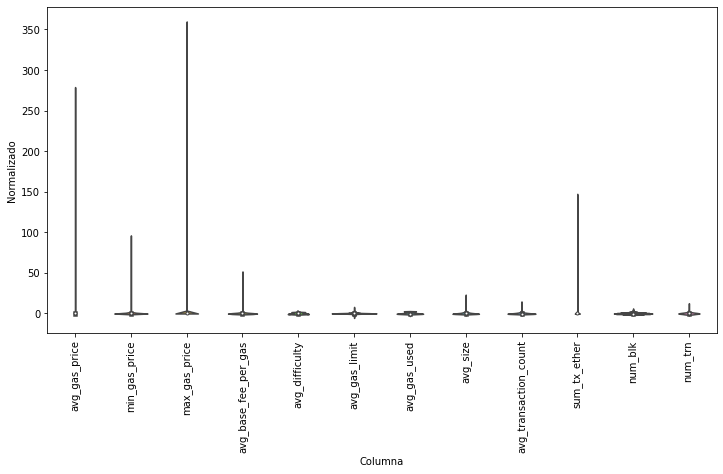

In [76]:
# Representar datos normalizados 
mean = df.mean()
std  = df.std()
df_normed = (df - mean) / std

df_toplot = df_normed.melt(var_name='Columna', value_name='Normalizado')
plt.figure(figsize=(12, 6))
ax = sns.violinplot(x='Columna', y='Normalizado', data=df_toplot)
_ = ax.set_xticklabels(df.keys(), rotation=90)

In [77]:
print ("mean df: ", mean)
print ("var  df: ", std)

mean df:  avg_gas_price            1.264246e+02
min_gas_price            9.980102e+01
max_gas_price            2.109894e+03
avg_base_fee_per_gas     1.074343e+02
avg_difficulty           9.825380e+15
avg_gas_limit            3.000432e+07
avg_gas_used             1.680461e+07
avg_size                 8.133269e+01
avg_transaction_count    2.157727e+02
sum_tx_ether             1.404892e+03
num_blk                  4.482169e+00
num_trn                  8.747685e+02
dtype: float64
var  df:  avg_gas_price            1.766149e+02
min_gas_price            7.194226e+01
max_gas_price            1.480164e+05
avg_base_fee_per_gas     6.739843e+01
avg_difficulty           8.617930e+14
avg_gas_limit            3.303342e+04
avg_gas_used             5.206880e+06
avg_size                 3.181571e+01
avg_transaction_count    8.366629e+01
sum_tx_ether             6.788365e+03
num_blk                  1.977930e+00
num_trn                  3.380424e+02
dtype: float64


In [78]:
# Eliminar filas con valores fuera del rango MAX_ZSCORE
MAX_ZSCORE = 3

df = df_org # Recuperamos el original
filas1 = df.shape[0]
from scipy import stats
df = df[(np.abs(stats.zscore(df)) < MAX_ZSCORE).all(axis=1)]
filas2 = df.shape[0]
print ("Filas eliminadas : ",filas1-filas2," de ", filas1, (filas1-filas2)/filas1*100, "%")

Filas eliminadas :  9044  de  129716 6.972154553023528 %


In [79]:
df.tail()

,avg_gas_price,min_gas_price,max_gas_price,avg_base_fee_per_gas,avg_difficulty,avg_gas_limit,avg_gas_used,avg_size,avg_transaction_count,sum_tx_ether,num_blk,num_trn
129721,112.776900,102.597533,293.900000,107.942640,1.156384e+16,2.998535e+07,2.844767e+07,152.596000,371.000000,1982.940424,2,742.0
129722,124.549098,101.833220,452.547873,110.820541,1.157759e+16,2.999999e+07,1.299718e+07,59.783143,130.285714,1140.048050,7,912.0
129723,126.749791,109.914606,511.149332,114.727834,1.158246e+16,2.997071e+07,2.144985e+07,103.212333,264.666667,775.291316,3,794.0
129724,142.455067,128.703035,968.287944,132.251091,1.156881e+16,2.994215e+07,1.669652e+07,90.444250,279.250000,1625.375807,4,1117.0
129726,135.709464,101.117227,465.646854,120.175149,1.155614e+16,2.995047e+07,1.161743e+07,60.122571,163.428571,947.064009,7,1144.0


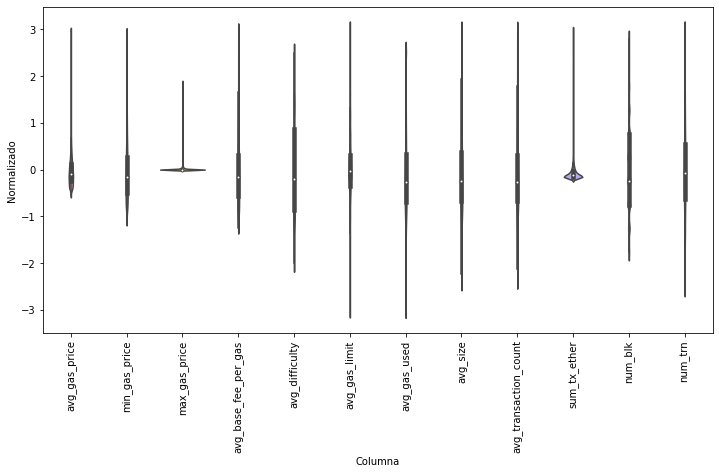

In [80]:
# Representar, de nuevo, datos normalizados 
#mean = df.mean()
#std  = df.std()
df_normed = (df - mean) / std

df_toplot = df_normed.melt(var_name='Columna', value_name='Normalizado')
plt.figure(figsize=(12, 6))
ax = sns.violinplot(x='Columna', y='Normalizado', data=df_toplot)
_ = ax.set_xticklabels(df.keys(), rotation=90)

In [81]:
# Volver a insertar tiempos
df = df.join(times)

In [82]:
# Guardar df limpio en Google Drive
df.to_csv(DS_FILE_CLEAN)